In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# Data Augmentation and Preprocessing Function
def augment_images(input_path, img_size=(100, 100)):
    # Define an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,            # Normalize pixel values (0-255 → 0-1)
        zoom_range=0.2,            # Randomly zoom images (up to 20%)
        horizontal_flip=True,       # Randomly flip images horizontally
        vertical_flip=True,         # Randomly flip images vertically
        rotation_range=20,          # Randomly rotate images (up to ±20 degrees)
        width_shift_range=0.2,      # Random horizontal shift (20% of width)
        height_shift_range=0.2,     # Random vertical shift (20% of height)
        shear_range=0.2,            # Shear transformations (20%)
        fill_mode='nearest'         # Fill missing pixels using nearest neighbors
    )

    images = []   # List to store image data
    labels = []   # List to store corresponding labels
    label_map = {}  # Dictionary to map class names to numerical labels

    # Loop through each disease category folder
    for idx, folder_name in enumerate(sorted(os.listdir(input_path))):
        folder_path = os.path.join(input_path, folder_name)

        if not os.path.isdir(folder_path):  # Skip if it's not a directory
            continue

        label_map[folder_name] = idx  # Assign numerical labels to categories

        # Loop through images in each folder
        for file_name in sorted(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file_name)
            file_extension = os.path.splitext(file_name)[1].lower()

            # Ensure the file is an image
            if file_extension in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}:
                image = cv2.imread(file_path)  # Read image using OpenCV
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                image = cv2.resize(image, img_size)  # Resize image to target size
                images.append(image)  # Add processed image to the list
                labels.append(idx)  # Assign numerical label to the image

    # Convert lists to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int')

    # One-hot encode the labels (needed for multi-class classification)
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_map))

    return images, labels, label_map  # Return processed images, labels, and category mapping


In [ ]:
# Load  Dataset
input_dataset_path = '/content/drive/MyDrive/project41/output_augmentation'  # Path to the dataset (update as needed)
train_images, train_labels, label_map = augment_images(input_dataset_path)  # Apply data augmentation and load images


In [ ]:
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
#Model Definition


# Import necessary modules from TensorFlow
from tensorflow.keras.applications import ResNet101  # Pre-trained ResNet-101 model
from tensorflow.keras.models import Model  # To define a custom model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D


# Load the ResNet101 model with pre-trained weights from ImageNet
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(100, 100, 3))


# Get the output from the base model
x = base_model.output

# Apply Global Average Pooling to reduce feature dimensions
x = GlobalAveragePooling2D()(x)  # Converts feature maps into a vector

# Fully connected (Dense) layers with ReLU activation
x = Dense(256, activation='relu')(x)  # 256 neurons for feature extraction
x = BatchNormalization()(x)  # Normalizes activations to stabilize training
x = Dropout(0.5)(x)  # Drops 50% of neurons to prevent overfitting

x = Dense(128, activation='relu')(x)  # Another fully connected layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(len(label_map), activation='softmax')(x)  # Assuming 32 classes for the EyeNet dataset

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
#Compile and Summary
from tensorflow.keras.optimizers import Adam

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 106, 106, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 25, 25, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 25, 25, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 25, 25, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 43,221,409 (164.88 MB)

 Trainable params: 562,465 (2.15 MB)

 Non-trainable params: 42,658,944 (162.73 MB)

In [ ]:
#Model Training
# Fit the model
history = model.fit(train_images, train_labels, epochs=32, batch_size=32, validation_split=0.2)


Epoch 1/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.1189 - loss: 3.8805 - val_accuracy: 0.3984 - val_loss: 2.2402
Epoch 2/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.4629 - loss: 1.8849 - val_accuracy: 0.7305 - val_loss: 1.0548
Epoch 3/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6682 - loss: 1.2644 - val_accuracy: 0.8555 - val_loss: 0.5994
Epoch 4/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7758 - loss: 0.8910 - val_accuracy: 0.9062 - val_loss: 0.4460
Epoch 5/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.8331 - loss: 0.6995 - val_accuracy: 0.9297 - val_loss: 0.3753
Epoch 6/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.8720 - loss: 0.5737 - val_accuracy: 0.9375 - val_loss: 0.2867
Epoch 7/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.8925 - loss: 0.4676 - val_accuracy: 0.9375 - val_loss: 0.2700
Epoch 8/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9063 - loss: 0.3915 - val_accuracy: 0.9453 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


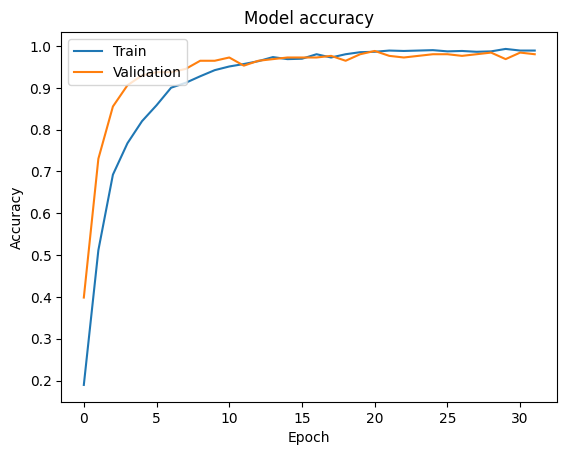

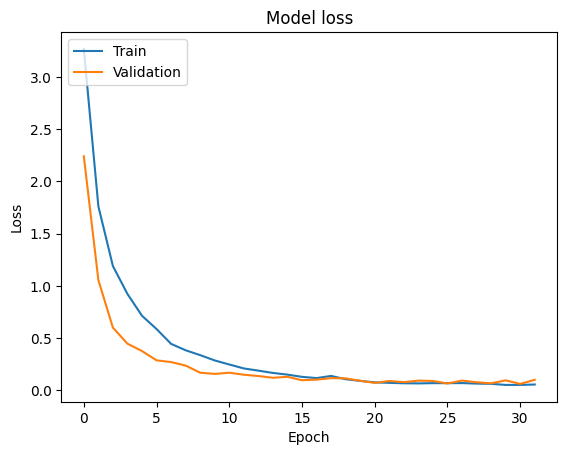

In [ ]:
# Access the history dictionary
print(history.history.keys())

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Assuming your model is already trained and test_images, test_labels are available
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, test_labels)




10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9821 - loss: 0.1005


for the confusion matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


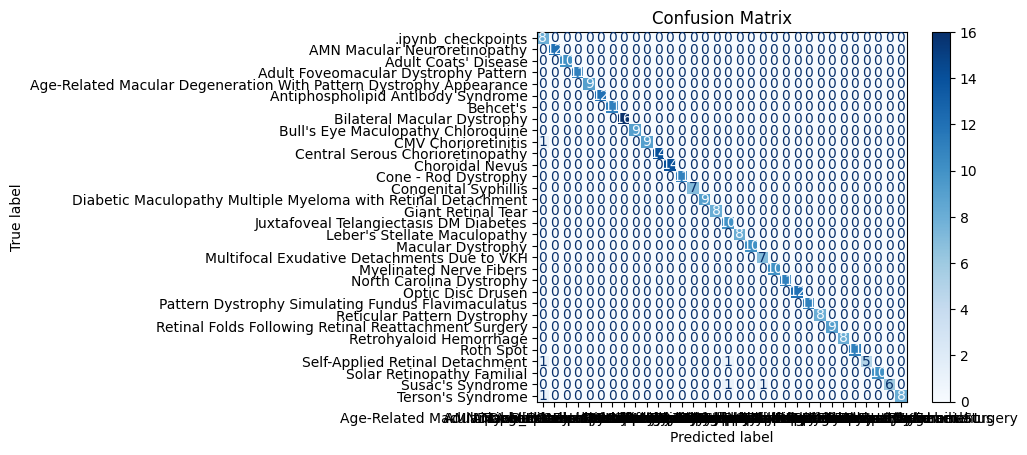

Classification Report:
                                                                    precision    recall  f1-score   support

                                                .ipynb_checkpoints       0.73      1.00      0.84         8
                                      AMN Macular Neuroretinopathy       1.00      1.00      1.00        12
                                              Adult Coats' Disease       1.00      1.00      1.00        10
                              Adult Foveomacular Dystrophy Pattern       1.00      1.00      1.00        11
Age-Related Macular Degeneration With Pattern Dystrophy Appearance       1.00      1.00      1.00         9
                                Antiphospholipid Antibody Syndrome       1.00      1.00      1.00        12
                                                          Behcet's       1.00      1.00      1.00        11
                                       Bilateral Macular Dystrophy       1.00      1.00      1.00        16
    

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Ensure label_map keys are in list format
label_names = list(label_map.keys())

# Check if the number of label names matches the number of classes
if len(label_names) != len(np.unique(y_true_classes)):
  print("Warning: Number of label names does not match number of classes. Rectifying...")
  # Adjust label_names to match the number of classes
  label_names = label_names[:len(np.unique(y_true_classes))]


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=label_names)

# Print the classification report
print("Classification Report:")
print(report)